<a href="https://colab.research.google.com/github/lephuocdat2000/Advanced-CV/blob/main/FinalProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import matplotlib.pyplot as plt
import numpy as np
from operator import itemgetter
import cv2
import timeit
import itertools 

Compile darknet

In [ ]:
%cd /content/drive/My\ Drive/darknet
!rm darknet
!make

In [4]:
!sed -i 's/OPENCV=0/OPENCV=1/' Makefile
!sed -i 's/GPU=0/GPU=1/' Makefile
!sed -i 's/CUDNN=0/CUDNN=1/' Makefile
!sed -i 's/CUDNN_HALF=0/CUDNN_HALF=1/' Makefile
!sed -i 's/LIBSO=0/LIBSO=1/' Makefile

In [75]:
def load_network_1(config_file, data_file, weights, batch_size=1):
    """
    load model description and weights from config files
    args:
        config_file (str): path to .cfg model file
        data_file (str): path to .data model file
        weights (str): path to weights
    returns:
        network: trained model
        class_names
        class_colors
    """
    network = load_net_custom(
        config_file.encode("ascii"),
        weights.encode("ascii"), 0, batch_size)
    metadata = load_meta(data_file.encode("ascii"))
    class_names = [metadata.names[i].decode("ascii") for i in range(1)]
    colors = class_colors(class_names)
    return network, class_names, colors

def darknet_helper(img, width, height):
  darknet_image = make_image(width, height, 3)
  img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img_resized = cv2.resize(img_rgb, (width, height),
                              interpolation=cv2.INTER_LINEAR)

  # get image ratios to convert bounding boxes to proper size
  img_height, img_width, _ = img.shape
  width_ratio = img_width/width
  height_ratio = img_height/height

  # run model on darknet style image to get detections
  copy_image_from_bytes(darknet_image, img_resized.tobytes())
  detections = detect_image(network, class_names, darknet_image)
  free_image(darknet_image)
  boxes = np.array([bbox2points(bbox) for _,_,bbox in detections])
  boxes = boxes * [width_ratio, height_ratio, width_ratio, height_ratio]
  return boxes

def MatrixCreation(A,B,C,D):
    width = int(max(np.sqrt((B[1]-A[1])**2+(B[0]-A[0])**2),np.sqrt((D[1]-C[1])**2+(D[0]-C[0])**2)))
    height = int(max(np.sqrt((C[1]-A[1])**2+(C[0]-A[0])**2),np.sqrt((D[1]-B[1])**2+(D[0]-B[0])**2)))
    inputs = np.float32([A,B,C,D])
    outputs = np.float32([[0,0],
                      [width-1,0],
                      [0,height-1],
                      [width-1,height-1]])
    M = cv2.getPerspectiveTransform(inputs,outputs)
    return M

def Points_Transformation(boxes):
    x_ = boxes[:,0]+(boxes[:,2]-boxes[:,0]) / 2
    # y_ = boxes[:,1]+(boxes[:,3]-boxes[:,1]) / 2
    y_ = boxes[:,3]
    x_ = np.expand_dims(x_,axis = 1)
    y_ = np.expand_dims(y_,axis = 1) 
    # centroids = np.uint32(np.concatenate((x_,y_),axis=1))
    centroids = np.concatenate((x_,y_),axis=1)
    #list_point_to_detect = np.float32(centroids).reshape(-1,1,2)
    list_point_to_detect = centroids.reshape(-1,1,2)
    transformed_points = cv2.perspectiveTransform(list_point_to_detect, M)
    transformed_points = transformed_points.reshape(transformed_points.shape[0],transformed_points.shape[2])
    return transformed_points

def DrawnRectangel(boxes,image,point,color):
    # xmin,ymin,xmax,ymax = int(boxes[point][0]),int(boxes[point][1]),int(boxes[point][2]),int(boxes[point][3])
    xmin,ymin,xmax,ymax = boxes[point][:].astype(int)
    cv2.rectangle(image,(int(xmin),int(ymin)),(int(xmax),int(ymax)),color,2)  
   
def video_processing(video_path,real_width,real_height,pixel_width,pixel_height):
    cap = cv2.VideoCapture(video_path)
    if (cap.isOpened()==False): 
        print('Error opening video stream or file')
    else: 
      fourcc = cv2.VideoWriter_fourcc(*'XVID')
      out = cv2.VideoWriter('output.avi',fourcc, 24, (960,540))
      while (True):
          ret, frame = cap.read()
          if ret==True:
            boxes = darknet_helper(frame,width,height)  
            #boxes= boxes[~np.all(boxes== 0, axis=1)]    
            transformed_points = Points_Transformation(boxes)
            if len(boxes) > 1:
                image_rect = frame.copy()
                list_indexes = list(itertools.combinations(range(len(transformed_points)), 2))
                x_y_ = []
                for i,pair in enumerate(itertools.combinations(transformed_points, r=2)):
                     if np.sqrt( ((pair[0][0] - pair[1][0])*real_width/pixel_width)**2 + ((pair[0][1] - pair[1][1])*real_height/pixel_height)**2  ) < int(distance_minimum):
                     #change color top view
                         index_pt1 = list_indexes[i][0]
                         index_pt2 = list_indexes[i][1]
                     #change color original frame
                         DrawnRectangel(boxes,image_rect,index_pt1,(0,0,255))
                         DrawnRectangel(boxes,image_rect,index_pt2,(0,0,255))
                         x_y_.append(index_pt1)
                         x_y_.append(index_pt2)

                # for i in range(0,len(transformed_points)-1):
                #       sub_vec = (transformed_points[i] - transformed_points[i+1:]) 
                #       distance = np.sqrt((sub_vec[:,0]*real_width/pixel_width)**2+(sub_vec[:,1]*real_height/pixel_height)**2)
                #       selected_points = np.array(np.where(distance<distance_minimum))[0]
                #       if (len(selected_points)>0):
                #           for j in selected_points:
                #               DrawnRectangel(boxes,image_rect,i+j+1,(0,0,255))
                #               x_y_.append(i+j+1)
                #           DrawnRectangel(boxes,image_rect,i,(0,0,255))
                #           x_y_.append(i)

                diff = np.setdiff1d(list(range(0,len(boxes))),np.unique(x_y_))
                for i in diff: DrawnRectangel(boxes,image_rect,i,(0,255,0))
                out.write(image_rect)
            elif len(boxes)==1: 
                 image_rect = frame.copy()
                 DrawnRectangel(boxes,image_rect,0,(0,255,0))
                 out.write(image_rect)
            else: out.write(frame)
            if cv2.waitKey(1)==ord('q'): break
          else: break 
    out.release()
    return
def show_webcam(mirror=False):
    vid = cv2.VideoCapture(0)
    while True:
       ret,frame = vid.read()
       plt.imshow('frame',frame)
       if cv2.waitKey(1) & 0xFF == ord('q'):
          break
    vid.release()
    cv2.destroyAllWindows() 


In [77]:
from darknet import *
#608X608
# load in our YOLOv4 architecture network
network, class_names, class_colors = load_network_1("cfg/yolov4.cfg", "cfg/coco.data", "yolov4.weights")
width = network_width(network)
height = network_height(network)



In [7]:
# Get transformation matrix
A = [390,220]
B = [840,220]
C = [10,450]
D = [900,450]
distance_minimum = 2.0
real_width,real_height = 7.5,8.0
pixel_width,pixel_height = B[0] - A[0], C[1]-A[1]
M = MatrixCreation(A,B,C,D)

(array([1225.41480351,  312.07970188]), array([770.33507873, 606.35643891]))
(array([1225.41480351,  312.07970188]), array([720.10295054, 618.10702444]))
(array([770.33507873, 606.35643891]), array([720.10295054, 618.10702444]))
1
712 333 852 712
636 430 765 743
1086 188 1181 345


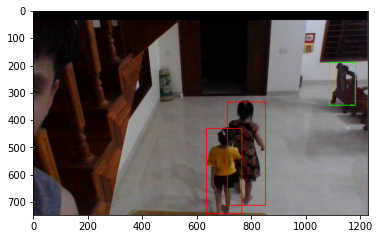

In [28]:
image = cv2.imread("/content/drive/MyDrive/Advanced-CV/193593992_323953159303430_8126787994321005785_n.png")
boxes = darknet_helper(image, width, height)
transformed_points = Points_Transformation(boxes)
if len(boxes) > 1:
    image_rect = image.copy()
    list_indexes = list(itertools.combinations(range(len(transformed_points)), 2))
    x_y_ = []
    for i,pair in enumerate(itertools.combinations(transformed_points, r=2)):
      if np.sqrt( ((pair[0][0] - pair[1][0])*real_width/pixel_width)**2 + ((pair[0][1] - pair[1][1])*real_height/pixel_height)**2  ) < int(distance_minimum):
      #change color top view
         index_pt1 = list_indexes[i][0]
         index_pt2 = list_indexes[i][1]
      #change color original frame
         DrawnRectangel(boxes,image_rect,index_pt1,(0,0,255))
         DrawnRectangel(boxes,image_rect,index_pt2,(0,0,255))
         x_y_.append(index_pt1)
         x_y_.append(index_pt2)
         diff = np.setdiff1d(list(range(0,len(boxes))),np.unique(x_y_))
         for i in diff: DrawnRectangel(boxes,image_rect,i,(0,255,0))
elif len(boxes)==1: 
    image_rect = image.copy()
    DrawnRectangel(boxes,image_rect,0,(0,255,0))
plt.imshow(cv2.cvtColor(image_rect,cv2.COLOR_BGR2RGB))
plt.show()

In [78]:
A = [250,130]
B = [750,130]
C = [10,310]
D = [870,310]
pixel_widtd,pixel_height = B[0] - A[0], C[1]-A[1]
M = MatrixCreation(A,B,C,D)
video_path='/content/drive/MyDrive/Advanced-CV/People2_Trim.mp4'
video_processing(video_path,real_width,real_height,pixel_width,pixel_height)

Test trên ảnh

4 points image

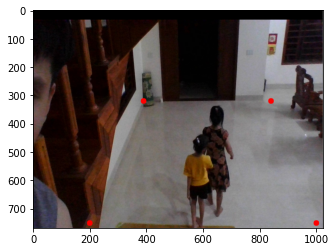

In [ ]:
image = cv2.imread('/content/drive/MyDrive/Advanced-CV/193593992_323953159303430_8126787994321005785_n.png')
image = cv2.resize(image,(1024,768))
cv2.circle(image,(390,320),10,(0,0,255),-1)
cv2.circle(image,(840,320),10,(0,0,255),-1)
cv2.circle(image,(200,750),10,(0,0,255),-1)
cv2.circle(image,(1000,750),10,(0,0,255),-1)
plt.imshow(cv2.cvtColor(image,cv2.COLOR_BGR2RGB))

4 points video

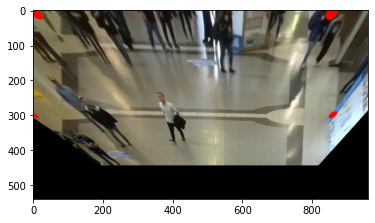

In [73]:
A = [250,130]
B = [750,130]
C = [10,310]
D = [870,310]
pixel_widtd,pixel_height = B[0] - A[0], C[1]-A[1]
M = MatrixCreation(A,B,C,D)
cap = cv2.VideoCapture('/content/drive/MyDrive/Advanced-CV/People2_Trim.mp4')
if (cap.isOpened()==False):
    print('Error opening video stream or file')
else: 
    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    while (True):
       ret, frame = cap.read()
       if ret==True:
           out = cv2.VideoWriter('output.avi',fourcc, 24,(frame.shape[1],frame.shape[0]))
           cv2.circle(frame,tuple(A),10,(0,0,255),-1)
           cv2.circle(frame,tuple(B),10,(0,0,255),-1)
           cv2.circle(frame,tuple(C),10,(0,0,255),-1)
           cv2.circle(frame,tuple(D),10,(0,0,255),-1)
           frame = cv2.warpPerspective(frame,M,(frame.shape[1],frame.shape[0]))
           plt.imshow(cv2.cvtColor(frame,cv2.COLOR_BGR2RGB))
           break
           if cv2.waitKey(1)==ord('q'): break
           out.write(frame)
       else: break
    out.release()